In [1]:
#!pip install praw transformers torch
import praw
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
import re


2024-05-29 18:26:57.174626: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
user_agent = "Brand sentiment analysis"
reddit = praw.Reddit(
  client_id="ujQpmAa-rxhI6tgE246E4w",
  client_secret="BnhybdI_fallhH64Us6vutIfsXP21Q",
  user_agent=user_agent
)

In [42]:
def fetch_reddit_posts(subreddit, query, limit=100):
    subreddit = reddit.subreddit(subreddit)
    posts = []
    for post in subreddit.search(query, limit=limit):
        if post.selftext and len(post.selftext.split()) > 6 and len(post.selftext.split()) <= 512:  # This checks if the body (selftext) is not empty
          posts.append([post.created_utc, post.title, post.selftext])
    df = pd.DataFrame(posts, columns=["Date", "Title", "Body"])
    df['Date'] = pd.to_datetime(df['Date'], unit='s')
    return df


In [43]:
df_chatgpt = fetch_reddit_posts('all', 'ChatGPT', 100)
df_gemini = fetch_reddit_posts('all', 'Gemini AI', 100)
df_copilot = fetch_reddit_posts('all', 'Copilot AI', 100)

In [45]:
def clean_text(text):
  text = re.sub(r'[^\x00-\x7F]+', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  return text.lower()

df_chatgpt['Body'] = df_chatgpt['Body'].apply(clean_text)
df_gemini['Body'] = df_gemini['Body'].apply(clean_text)
df_copilot['Body'] = df_copilot['Body'].apply(clean_text)
df_chatgpt['Title'] = df_chatgpt['Title'].apply(clean_text)
df_gemini['Title'] = df_gemini['Title'].apply(clean_text)
df_copilot['Title'] = df_copilot['Title'].apply(clean_text)

In [46]:
df_copilot

,Date,Title,Body
0,2024-03-08 14:40:04,anyone using microsoft copilot ai,my cheap ass company has microsoft dynamics 36...
1,2023-12-10 01:06:42,copilot ai assistant,hello all i was looking for some feedback and ...
2,2024-05-22 13:26:02,ai will replace us all but in the meantime my ...,i work for a 5000 employee company we are bann...
3,2024-03-04 01:06:29,copilot ai max payne 2 cover,i been trying copilot ai asked it to draw a co...
4,2023-09-08 13:16:00,microsoft says it will take the heat if copilo...,microsoft is offering legal protection to com...
5,2024-05-25 17:36:53,copilot ai,odd i asked copilot of it is self aware and if...
6,2024-04-11 18:47:09,which copilotai model for kotlin,i have been brutally unimpressed for copilots ...
7,2024-03-01 08:14:35,microsoft introduces copilot ai chatbot,microsoft recently unveiled its latest innovat...
8,2023-03-16 15:53:39,breaking microsoft announces ai copilot in wor...,microsoft has announced that they are adding a...
9,2024-01-16 10:07:35,microsoft unlocks copilot ai inside office app...,microsoft is making its aipowered copilot ava...


In [49]:
# Load sentiment analysis pipeline
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

def truncate_text(text, max_tokens=512):
    tokens = tokenizer.tokenize(text)
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
    return tokenizer.convert_tokens_to_string(tokens)

def get_sentiment_score(text):
    truncated_text = truncate_text(text)
    result = sentiment_pipeline(truncated_text)[0]
    return result['label'], result['score']

# Apply sentiment analysis
df_chatgpt['Sentiment'], df_chatgpt['Sentiment_Score'] = zip(*df_chatgpt['Body'].apply(get_sentiment_score))
df_gemini['Sentiment'], df_gemini['Sentiment_Score'] = zip(*df_gemini['Body'].apply(get_sentiment_score))
df_copilot['Sentiment'], df_copilot['Sentiment_Score'] = zip(*df_copilot['Body'].apply(get_sentiment_score))

In [51]:
# Display sentiment statistics
print("ChatGPT Sentiment Statistics:")
print(df_chatgpt['Sentiment'].value_counts(normalize=True))

print("Gemini AI Sentiment Statistics:")
print(df_gemini['Sentiment'].value_counts(normalize=True))

print("Copilot AI Sentiment Statistics:")
print(df_copilot['Sentiment'].value_counts(normalize=True))


ChatGPT Sentiment Statistics:
Sentiment
NEGATIVE    0.631579
POSITIVE    0.368421
Name: proportion, dtype: float64
Gemini AI Sentiment Statistics:
Sentiment
NEGATIVE    0.758621
POSITIVE    0.241379
Name: proportion, dtype: float64
Copilot AI Sentiment Statistics:
Sentiment
NEGATIVE    0.793103
POSITIVE    0.206897
Name: proportion, dtype: float64


In [58]:
df_chatgpt

,Date,Title,Body,Sentiment,Sentiment_Score
0,2023-04-30 11:06:08,what do you all actually use chatgpt for,chatgpt is cool and has many every now and the...,POSITIVE,0.996746
1,2023-05-23 16:13:52,chatgpt is the devil,four students so far have used chatgpt to writ...,NEGATIVE,0.997872
2,2024-04-05 17:57:45,kids think chatgpt is going to save them turni...,love what just happened my students turned in ...,NEGATIVE,0.975814
3,2024-03-07 21:55:30,chatgpt is a doubleedged sword,tldr tell chatgpt to explain the solution rath...,NEGATIVE,0.998859
4,2023-04-09 11:07:32,chatgpt assistant chatgpt keyboard for ios use...,last week we shared omni ai while the idea see...,NEGATIVE,0.998553
5,2024-03-13 23:02:01,obvious chatgpt prompt reply in published paper,look it up crazy how it good through peer review,POSITIVE,0.999517
6,2024-02-01 17:14:57,chatgpt saved me 250,tldr chatgpt helped me jump start my hybrid to...,NEGATIVE,0.998795
7,2023-11-24 15:15:56,chatgpt has become unusably lazy,i asked chatgpt to fill out a csv file of 15 e...,NEGATIVE,0.999042
8,2023-11-07 15:14:51,top 20 rappers by chatgpt,the question i asked was who are the top 20 be...,POSITIVE,0.994741
9,2023-04-26 17:46:33,video call with chatgpt,hi everyone weve built a realtime video friend...,NEGATIVE,0.985319


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


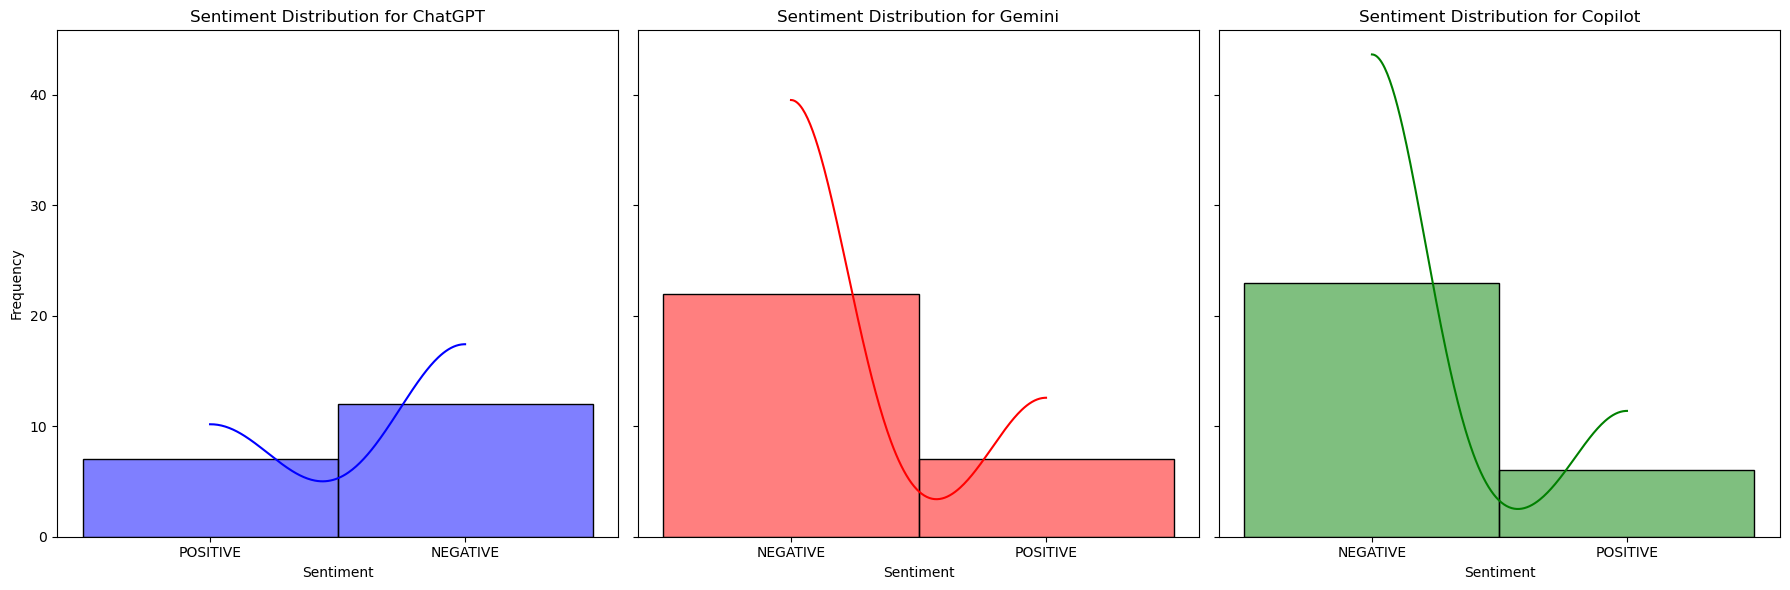

In [54]:
# Plot sentiment distribution for ChatGPT
# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot sentiment distribution for ChatGPT
sns.histplot(df_chatgpt['Sentiment'], kde=True, color='blue', ax=axes[0])
axes[0].set_title('Sentiment Distribution for ChatGPT')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Frequency')

# Plot sentiment distribution for Gemini
sns.histplot(df_gemini['Sentiment'], kde=True, color='red', ax=axes[1])
axes[1].set_title('Sentiment Distribution for Gemini')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Frequency')

# Plot sentiment distribution for Copilot
sns.histplot(df_copilot['Sentiment'], kde=True, color='green', ax=axes[2])
axes[2].set_title('Sentiment Distribution for Copilot')
axes[2].set_xlabel('Sentiment')
axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()